In [ ]:
!pip install pandas openai sentence-transformers networkx

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
# 1. Subir y leer el archivo
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving tripletas_gemma_lemma.json to tripletas_gemma_lemma.json


In [ ]:
import json
# 2. Leer y verificar el contenido
with open(filename, 'r', encoding='utf-8') as f:
    entidades = json.load(f)

In [ ]:
# 2. Función para verificar y limpiar cada elemento
def limpiar_elemento(elemento):
    if isinstance(elemento, dict):
        # Verificar que tenga todas las claves necesarias
        keys_requeridas = {'head', 'head_type', 'relation', 'tail', 'tail_type'}
        if all(key in elemento for key in keys_requeridas):
            return elemento
    return None

In [ ]:
# 3. Limpiar la lista
entidades_limpias = [elem for elem in entidades if limpiar_elemento(elem)]

In [ ]:
# 4. Verificar la limpieza
print(f"Elementos originales: {len(entidades)}")
print(f"Elementos válidos: {len(entidades_limpias)}")

Elementos originales: 18556
Elementos válidos: 18556


In [ ]:
# 5. Mostrar ejemplo de elementos válidos e inválidos
print("\nPrimer elemento válido:")
print(json.dumps(entidades_limpias[0], indent=2, ensure_ascii=False))


Primer elemento válido:
{
  "head": "aguas medicinales",
  "head_type": "tema",
  "relation": "relacionado con",
  "tail": "baños y humeros",
  "tail_type": "tema"
}


In [ ]:
# Obtener listas de elementos únicos para cada clave
heads = set()
relations = set()
tails = set()

for entry in entidades:
    if isinstance(entry, dict):
        heads.add(entry.get("head"))
        relations.add(entry.get("relation"))
        tail = entry.get("tail")
        # Check if tail is a list and convert it to a tuple
        if isinstance(tail, list):
            tail = tuple(tail)
        tails.add(tail)

# Contar el número de elementos únicos en cada lista
num_heads = len(heads)
num_relations = len(relations)
num_tails = len(tails)

# Imprimir los resultados
print("Número de heads:", num_heads)
print("Número de relations:", num_relations)
print("Número de tails:", num_tails)

Número de heads: 845
Número de relations: 819
Número de tails: 1073


In [ ]:
import pandas as pd

In [ ]:
# 6. Crear el DataFrame
try:
    kg_relations = pd.DataFrame(entidades_limpias)
    print("\nDataFrame creado exitosamente!")
    print("\nColumnas:", kg_relations.columns.tolist())
    print("\nPrimeras 3 filas:")
    print(kg_relations.head(3))

    # 7. Información básica del DataFrame
    print("\nInformación del DataFrame:")
    print(kg_relations.info())
except Exception as e:
    print("\nError al crear el DataFrame:", e)

    # 8. Si hay error, mostrar más detalles sobre los datos
    print("\nDetalles de los primeros 5 elementos:")
    for i, elem in enumerate(entidades_limpias[:5]):
        print(f"\nElemento {i}:")
        print(f"Tipo: {type(elem)}")
        print(f"Contenido: {elem}")


DataFrame creado exitosamente!

Columnas: ['head', 'head_type', 'relation', 'tail', 'tail_type']

Primeras 3 filas:
                             head head_type         relation  \
0               aguas medicinales      tema  relacionado con   
1  doctor josé ignacio bartolache   persona               es   
2                miguel fernández   persona               es   

                                tail tail_type  
0                    baños y humeros      tema  
1        apartador general del reino     cargo  
2  promotor fiscal del protomedicato     cargo  

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736 entries, 0 to 1735
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   head       1736 non-null   object
 1   head_type  1736 non-null   object
 2   relation   1736 non-null   object
 3   tail       1736 non-null   object
 4   tail_type  1736 non-null   object
dtypes: object(5)
memor

In [ ]:
kg_relations.head()

head head_type               relation  \
0               aguas medicinales      tema        relacionado con   
1  doctor josé ignacio bartolache   persona                     es   
2                miguel fernández   persona                     es   
3  doctor josé ignacio bartolache   persona  inspeccionó junto con   
4                miguel fernández   persona  inspeccionó junto con   

                                tail tail_type  
0                    baños y humeros      tema  
1        apartador general del reino     cargo  
2  promotor fiscal del protomedicato     cargo  
3                   miguel fernández   persona  
4     doctor josé ignacio bartolache   persona

In [ ]:
# Convertir la lista de diccionarios en un DataFrame
#kg_relations = pd.DataFrame(entidades)

# Mostrar el DataFrame
#kg_relations.head()

In [ ]:
# Guardar el resultado normalizado en un nuevo archivo JSON
normalized_filename = 'kg_relations_gpt4o.csv'
kg_relations.to_csv(normalized_filename)

# Descargar el archivo JSON normalizado
files.download(normalized_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#kg_relations.to_csv("/content/drive/MyDrive/KGLLM/gpt4o_relations.csv")

In [ ]:
from sentence_transformers import SentenceTransformer, util

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
heads = kg_relations['head'].values
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedding_model.encode(heads)
similarity = util.cos_sim(embeddings[0], embeddings[1])

In [ ]:
import networkx as nx

G = nx.Graph()
for _, row in kg_relations.iterrows():
    # Make sure head and tail are not lists and are not None
    head = row['head']
    if isinstance(head, list):
        head = head[0]  # Or handle the list in another way if needed
    if head is None: # Handle the case where head is None
        continue # Skip to the next row

    tail = row['tail']
    if isinstance(tail, list):
        tail = tail[0]  # Or handle the list in another way if needed
    if tail is None: # Handle the case where tail is None
        continue # Skip to the next row

    G.add_edge(head, tail, label=row['relation']) # Now head and tail should be valid nodes

In [ ]:
communities_generator = nx.community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)

# Convert all nodes within each community to strings before sorting
communities = sorted([sorted(str(node) for node in community)
                     for community in next_level_communities])

print("Number of Communities = ", len(communities))
print(communities)

Number of Communities =  284
[[' piscar', ' segar', 'actividades normales', 'ciego de nacimiento', 'ciego por las viruelas', 'dámaso de aceves', 'habilidades excepcionales', 'hombres ciegos', 'ignacio ibarra', 'juan rivera'], ['(ciudad/barrio)', 'boticas', 'el tema del texto', 'protomedicato de méxico'], ['1 de noviembre', '1 suplemento con láminas', '12 de diciembre de 2023', '16 de enero de 1985', '9 tomos', 'abril', 'acapulco', 'acme corp', 'agave y begonia', 'agosto', 'aguaje de santa cecilia', 'alcalde', 'alemania', 'almacén y tienda', 'alonso núñez de haro', 'ambrosio de llanos y valdés', 'américa del norte', 'andrés caballero', 'andrés manuel lópez obrador', 'antillas', 'antimonio', 'antonio vecino', 'anuncio del nuevo plan económico', 'anuncio del presidente', 'apartador general del reino', 'arrope antigálico de barcelona', 'arzobispo de méxico', 'atención médica', 'audiencia gobernadora', 'augsburgo', 'autor del libro de medicina', 'auxiliar a los enfermos', 'ayuntamiento de m

In [ ]:
import seaborn as sns
import random
palette = "hls"

## Now add these colors to communities and make another dataframe
def colors2Community(communities) -> pd.DataFrame:
    ## Define a color palette
    p = sns.color_palette(palette, len(communities)).as_hex()
    random.shuffle(p)
    rows = []
    group = 0
    for community in communities:
        color = p.pop()
        group += 1
        for node in community:
            rows += [{"node": node, "color": color, "group": group}]
    df_colors = pd.DataFrame(rows)
    return df_colors


colors = colors2Community(communities)
colors

node    color  group
0                     piscar  #57db5a      1
1                      segar  #57db5a      1
2       actividades normales  #57db5a      1
3        ciego de nacimiento  #57db5a      1
4     ciego por las viruelas  #57db5a      1
...                      ...      ...    ...
1677       sustancia química  #5771db    283
1678          álcali volátil  #5771db    283
1679         tlatlalquáhuitl  #db57c2    284
1680          yerba del cura  #db57c2    284
1681             yerba dulce  #db57c2    284

[1682 rows x 3 columns]

In [ ]:
import networkx as nx

for index, row in colors.iterrows():
    # Check if 'node' is valid and not NaN before accessing G
    if pd.notna(row['node']):
        node_str = str(row['node'])  # Convert node to string outside the indexing operation
        if node_str in G.nodes:  # Check if the node exists in the graph
            G.nodes[node_str]['group'] = row['group']
            G.nodes[node_str]['color'] = row['color']
            G.nodes[node_str]['size'] = G.degree[node_str]
        else:
            print(f"Warning: Node '{node_str}' not found in the graph.")

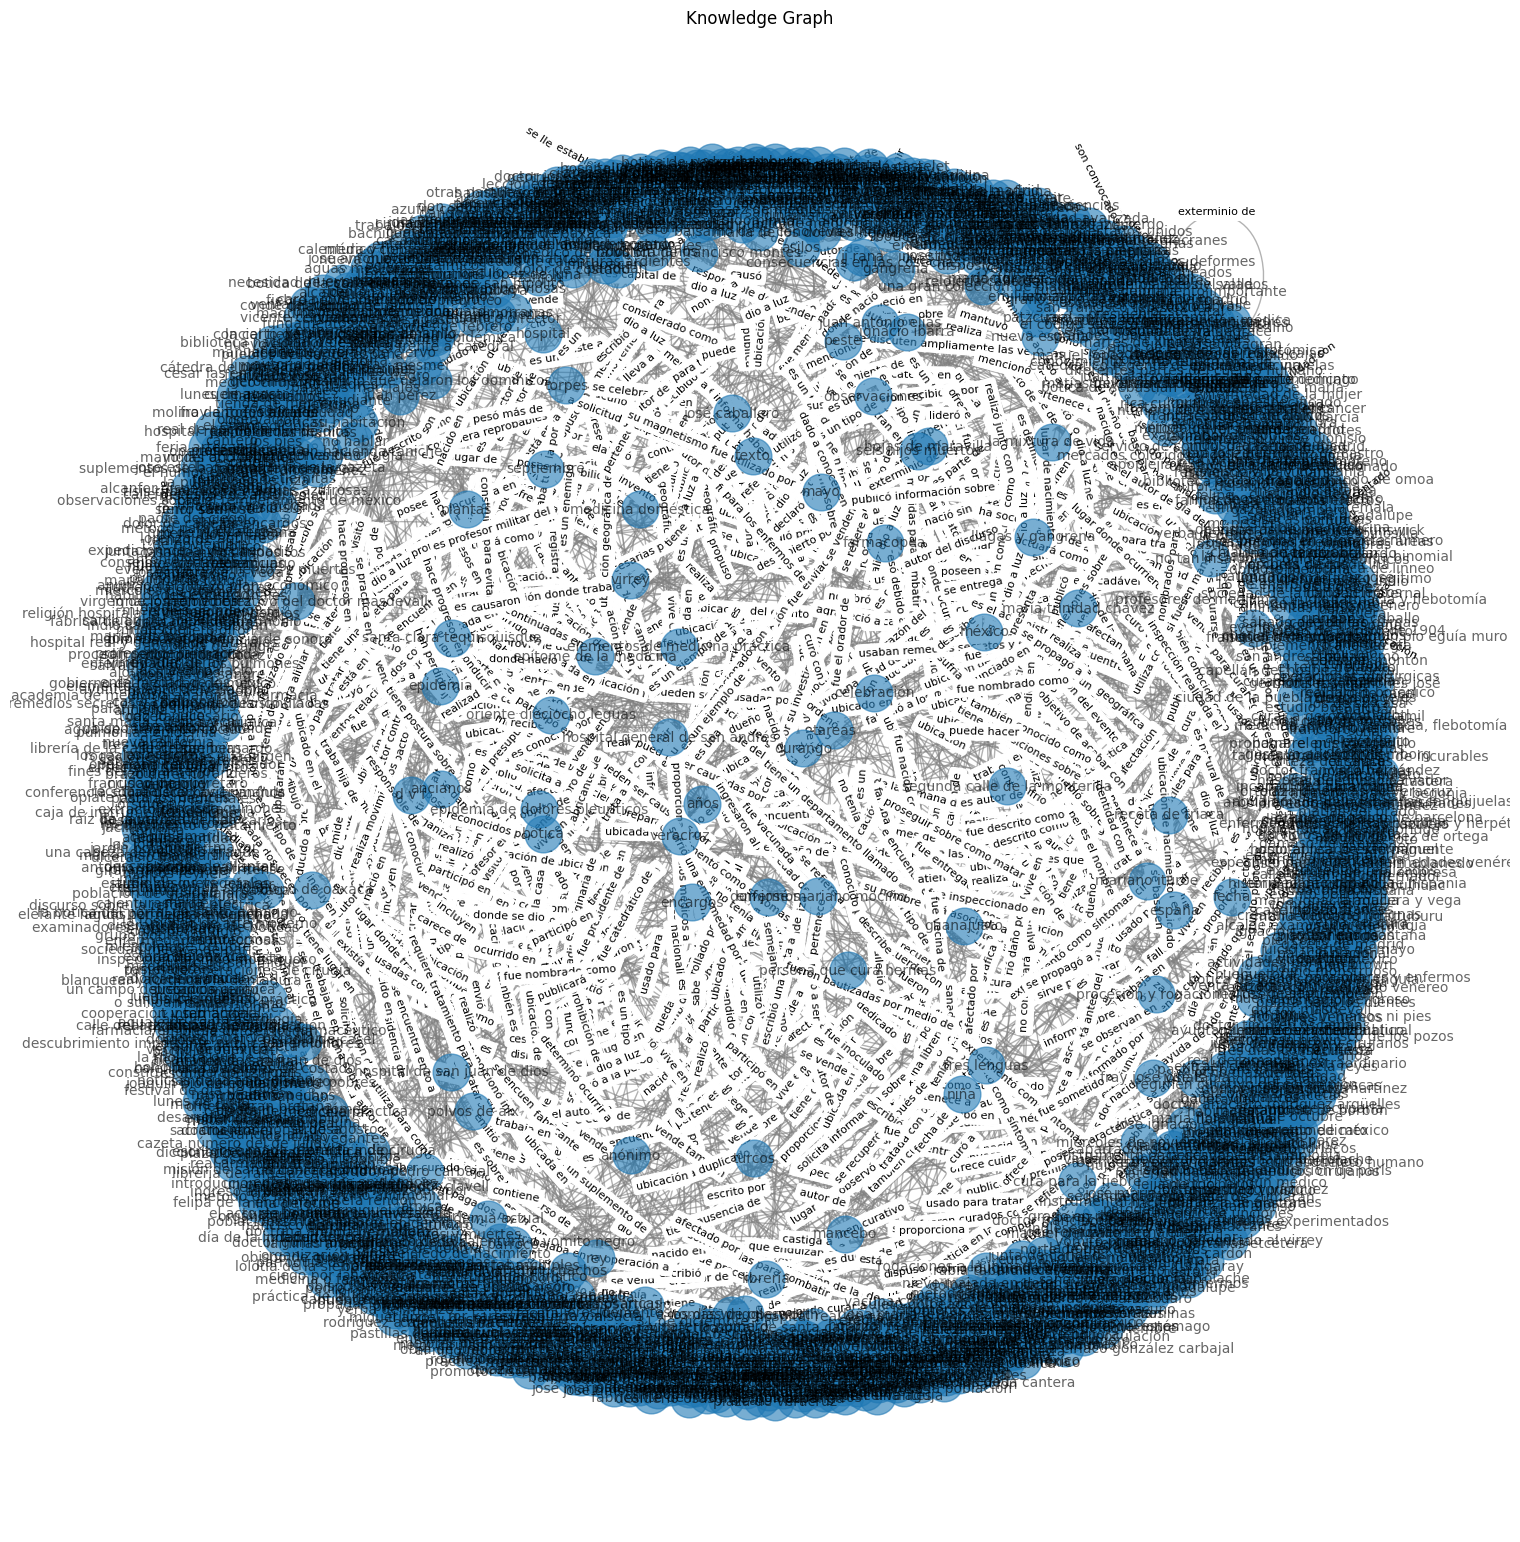

In [ ]:
import matplotlib.pyplot as plt


pos = nx.spring_layout(G, seed=47, k=0.9)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(15, 15))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, edge_color='gray', alpha=0.6) #node_color='lightblue'
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('Knowledge Graph')
plt.show()

In [ ]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.7 MB/s eta 0:00:00


In [ ]:
from pyvis.network import Network
import json
from google.colab import files
import networkx as nx  # Asegúrate de que `networkx` esté importado si no lo has hecho ya

graph_output_directory = "Llama_ejemplo_0.html"

# Crear archivo JSON (opcional y no se utiliza en la visualización del grafo)
with open(graph_output_directory, 'w') as f:
    json.dump(graph_output_directory, f, ensure_ascii=False, indent=4)

# Descargar el archivo JSON (opcional)
files.download(graph_output_directory)

# Inicializa la visualización de la red
net = Network(
    notebook=False,
    bgcolor="#FFFF",
    cdn_resources="remote",
    height="900px",
    width="100%",
)

# Filtra los nodos para incluir solo aquellos con al menos dos vecinos
filtered_nodes = [node for node, degree in G.degree() if degree >= 2]
filtered_graph = G.subgraph(filtered_nodes)  # Crea un subgrafo solo con los nodos filtrados

# Modifica el grosor de las aristas basado en el grado de los nodos conectados
for u, v, d in filtered_graph.edges(data=True):
    # Calcula el grado promedio de los nodos conectados por la arista
    degree_u = filtered_graph.degree(u)
    degree_v = filtered_graph.degree(v)
    avg_degree = (degree_u + degree_v) / 2
    avg_degree = avg_degree * 5

    # Ajusta el grosor (value) de la arista
    d["value"] = avg_degree   # Ajusta el multiplicador según sea necesario
    d["label"] = ""  # Elimina o vacía la etiqueta de cada arista si es necesario

# Agrega nodos y bordes al grafo de PyVis
net.from_nx(filtered_graph)

# Configura el tamaño de los nodos basado en su grado
for node in filtered_graph.nodes():
    net.get_node(node)["size"] = filtered_graph.degree(node) * 8  # Ajusta el tamaño según el grado del nodo



# Muestra botones de interacción (opcional)
net.show_buttons()

# Genera la visualización del grafo
net.show(graph_output_directory, notebook=False)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Llama_ejemplo_0.html


In [ ]:
#import IPython

#net.save_graph("Graph_llama3.html")
#IPython.display.HTML(filename="Graph_llama3.html")

In [ ]:
!pip install RDFLib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 9.8 MB/s eta 0:00:00


In [ ]:
import json
from rdflib import Graph, URIRef, Literal, RDF, Namespace

# Asegúrate de que 'data' sea una lista de diccionarios, no una cadena
data = json.loads(entidades_limpias) if isinstance(entidades_limpias, str) else entidades_limpias

prefixes = '''
@prefix ex: <http://example.org/> .
@prefix dbo: <http://dbpedia.org/ontology/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix schema: <http://schema.org/> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix org: <https://www.w3.org/ns/org#> .  # Organization Ontology
@prefix time: <http://www.w3.org/2006/time#> .  # Time Ontology
'''

def entity_to_uri(entity):
    if entity is None:  # Check if entity is None
        return "ex:None"  # Or any other suitable representation for None
    if isinstance(entity, list):
        # Handle the case where entity is a list, e.g., join the elements
        entity = "_".join(entity)
    return f"ex:{entity.replace(' ', '_')}"

def entity_type_to_class(entity_type):
    if isinstance(entity_type, list):
        # Handle the case when entity_type is a list
        entity_type = "_".join(entity_type)  # Or any other suitable handling

    type_map = {
        "persona": "foaf:Person",
        "lugar": "schema:Place",
        "lugares": "schema:Place",
        "país": "schema:Place",
        "ubicación": "schema:Place",
        "locación": "schema:Place",
        "fecha": "dbo:Date",
        "organización": "foaf:Organization",
        "fechas": "dbo:Date",
        "número": "dbo:float",
        "evento": "dbo:NaturalEvent",
        "evento natural": "dbo:NaturalEvent",
        "infraestuctura": "dbo:Infrastructure",

    }
    return type_map.get(entity_type, "dbo:Thing")

turtle_data = prefixes + "\n"
for item in data:
    # Asegúrate de que 'item' sea un diccionario en cada iteración
    if not isinstance(item, dict):
        print(f"Error: Esperaba un diccionario, pero obtuve {type(item)}. Saltando.")
        continue

    # Acceder a 'head' y 'tail' directamente como claves del diccionario
    head_uri = entity_to_uri(item.get("head"))
    tail_uri = entity_to_uri(item.get("tail"))

    # Acceder a 'head_type' y 'tail_type', con un valor predeterminado si no están presentes
    head_class = entity_type_to_class(item.get("head_type", "dbo:Thing"))
    tail_class = entity_type_to_class(item.get("tail_type", "dbo:Thing"))

    relation = item.get("relation", "").replace(" ", "_")

    # Construir los triples en formato Turtle
    turtle_data += f"{head_uri} a {head_class} ;\n"
    turtle_data += f"    ex:{relation} {tail_uri} .\n"
    turtle_data += f"{tail_uri} a {tail_class} .\n\n"

# Escribir los datos Turtle en un archivo
output_file = "/content/entidades.ttl"
with open(output_file, "w") as file:
    file.write(turtle_data)

# Descargar el archivo en Google Colab
from google.colab import files
files.download(output_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>